In [ ]:
# BSD 3-Clause License
#
# This file is part of the Basalt project.
# https://gitlab.com/VladyslavUsenko/basalt.git
#
# Copyright (c) 2019-2021, Vladyslav Usenko and Nikolaus Demmel.
# All rights reserved.

In [1]:
from pathlib import Path

import numpy as np
from mpmath import mp, mpf
import math
from mpmath import matrix, randmatrix, norm
mpf("inf")
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from pnec.scf import fibonacci_sphere, obj_fun, scf
from pnec.common import pnec_energy_translations, rotation_between_points, skew
from pnec.simulation.load_experiment import load_problem


In [2]:
def getAi_Bi(bvs_1, bvs_2, r_start, Sigma):
    n = 3
    k = bvs_1.shape[0]
    reg = 1e-5

    Ai = np.zeros((k, n, n))
    for i in range(k):
        n_i = np.cross(bvs_1[i, :], np.dot(
            r_start, bvs_2[i, :]))
        #print(n_i)
        Ai[i, :, :] = - np.outer(n_i, n_i)
    Bi_reg = np.zeros((k, n, n))
    for i in range(k):
        skew_f = skew(bvs_1[i, :])
        B = np.linalg.multi_dot(
            [skew_f, r_start, Sigma[i, :, :], r_start.transpose(), skew_f.transpose()])
        Bi_reg[i, :, :] = ((B + B.transpose()) / 2.0) + reg*np.eye(n)[None]

    return Ai, Bi_reg


In [3]:
def best_translation(bvs_1, bvs_2, rotation, sigmas):
    Ai, Bi = getAi_Bi(bvs_1, bvs_2, rotation, sigmas)

    X = fibonacci_sphere(samples=500000)
    fun_vals = obj_fun(X, Ai, Bi)
    topk = np.argsort(-fun_vals)[:1]
    X = X[topk]
    Xs, funs, res = scf(X, Ai, Bi)
    energy_scf = pnec_energy_translations(Xs[-1][0][None, None], rotation, bvs_1,
                                          bvs_2, sigmas)
    energy_fib = pnec_energy_translations(X[None], rotation, bvs_1,
                                          bvs_2, sigmas)

    if energy_fib < energy_scf:
        best_t = Xs[-1][0]
    else:
        best_t = X[0]

    return best_t


In [4]:
def mesh_of_translations(n: int, m: int, max_theta: float, base_translation: np.array):
    # returns a mesh of size (n, m) of translations around the base_translation with a maximum theta
    theta = np.linspace(0, max_theta * np.pi / 180, n)
    phi = np.linspace(0, 2*np.pi, m)

    ttheta, pphi = np.meshgrid(theta, phi, indexing='ij')

    ts = np.stack([np.cos(pphi) * np.sin(ttheta), np.sin(pphi)
                   * np.sin(ttheta), np.cos(ttheta)], axis=2)

    R = rotation_between_points(np.array([0, 0, 1]), base_translation)
    return np.einsum('ij,klj->kli', R, ts), ttheta, pphi

In [5]:
def evaluate_experiment(path: Path, omnidirectional: bool, problem_num: int, without_t: bool):
    n = 1 + 100
    m = 1 + 100
    max_theta = 90
    gt_pose, bvs_1, bvs_2, sigmas = load_problem(path, omnidirectional, problem_num, False)

    t = gt_pose.translation()
    if without_t:
        t = best_translation(bvs_1, bvs_2, gt_pose.rotationMatrix(), sigmas)
    t = t / np.linalg.norm(t)

    # first iteration
    ts, ttheta, pphi = mesh_of_translations(n, m, max_theta, t)

    energy = pnec_energy_translations(
        ts, gt_pose.rotationMatrix(), bvs_1, bvs_2, sigmas)

    t_argmin = np.unravel_index(energy.argmin(), energy.shape)
    t_min = ts[t_argmin[0], t_argmin[1], :]

    # second iteration
    ts, ttheta, pphi = mesh_of_translations(n, m, max_theta, t_min)

    energy = pnec_energy_translations(
        ts, gt_pose.rotationMatrix(), bvs_1, bvs_2, sigmas)

    t_argmin = np.unravel_index(energy.argmin(), energy.shape)
    t_min = ts[t_argmin[0], t_argmin[1], :]
    
    return energy, ttheta, pphi


## Load Experiment without translation
### get the best energy using the fibonacci residual

In [6]:
base_folder = Path('/Volumes/Samsung_T5/new_experiments/normal')
omnidirectional = True
noise_type = 'anisotropic_inhomogeneous'
noise_level = '1.000000'
problem_number = 13

if omnidirectional:
    camera_folder = base_folder.joinpath('omnidirectional')
else:
    camera_folder = base_folder.joinpath('pinhole')
path_1 = camera_folder.joinpath(noise_type, noise_level)
path_2 = camera_folder.joinpath(noise_type + '_no_t', noise_level)

energy_1, ttheta_1, pphi_1 = evaluate_experiment(path_1, omnidirectional, problem_number, False)

energy_2, ttheta_2, pphi_2 = evaluate_experiment(
    path_2, omnidirectional, problem_number, True)


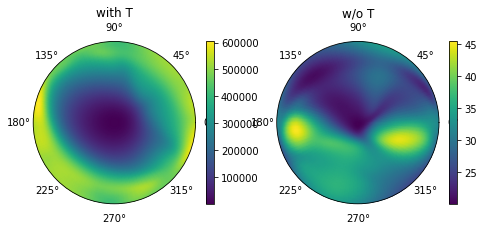

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(
    8, 3), subplot_kw=dict(projection='polar'))

ax = axs[0]
cm1 = ax.pcolormesh(pphi_1, ttheta_1, energy_1,
                    shading='gouraud')
ax.set_yticks([])
ax.set_title("with T")
fig.colorbar(cm1, ax=ax, orientation='vertical')

ax = axs[1]
cm2 = ax.pcolormesh(pphi_2, ttheta_2, energy_2,
                    shading='gouraud')
ax.set_yticks([])
ax.set_title("w/o T")
fig.colorbar(cm2, ax=ax, orientation='vertical')
